Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from /content/drive/MyDrive/FlatFiles/NGAsub_MegaFlatfile_RotD50_050_R211022_public.xlsx...
Data Prepared Successfully.
Input Features: ['Mw', 'log10_Vs30', 'R_rup', 'log10_R_rup', 'F_-999', 'F_0', 'F_1', 'F_2', 'F_3', 'F_4']
Targets: ['log10_PGA', 'log10_PGV', 'log10_PSA_0.1s', 'log10_PSA_1.0s']
Training Samples: 52157

--- Running Experiment 1: Batch Size vs LR ---

Training Model - LR: 0.001, Batch Size: 16
   Epoch 1: Train MSE = 0.2598, Val MSE = 0.1875
   Epoch 2: Train MSE = 0.1934, Val MSE = 0.1907
   Epoch 3: Train MSE = 0.1897, Val MSE = 0.1779
   Epoch 4: Train MSE = 0.1877, Val MSE = 0.1758
   Epoch 5: Train MSE = 0.1855, Val MSE = 0.1745
   Epoch 6: Train MSE = 0.1850, Val MSE = 0.1818
   Epoch 7: Train MSE = 0.1835, Val MSE = 0.1815
   Epoch 8: Train MSE = 0.1826, Val MSE = 0.1734
   Epoch 9: Train MSE = 0.1823, Val MSE = 0.1721
   

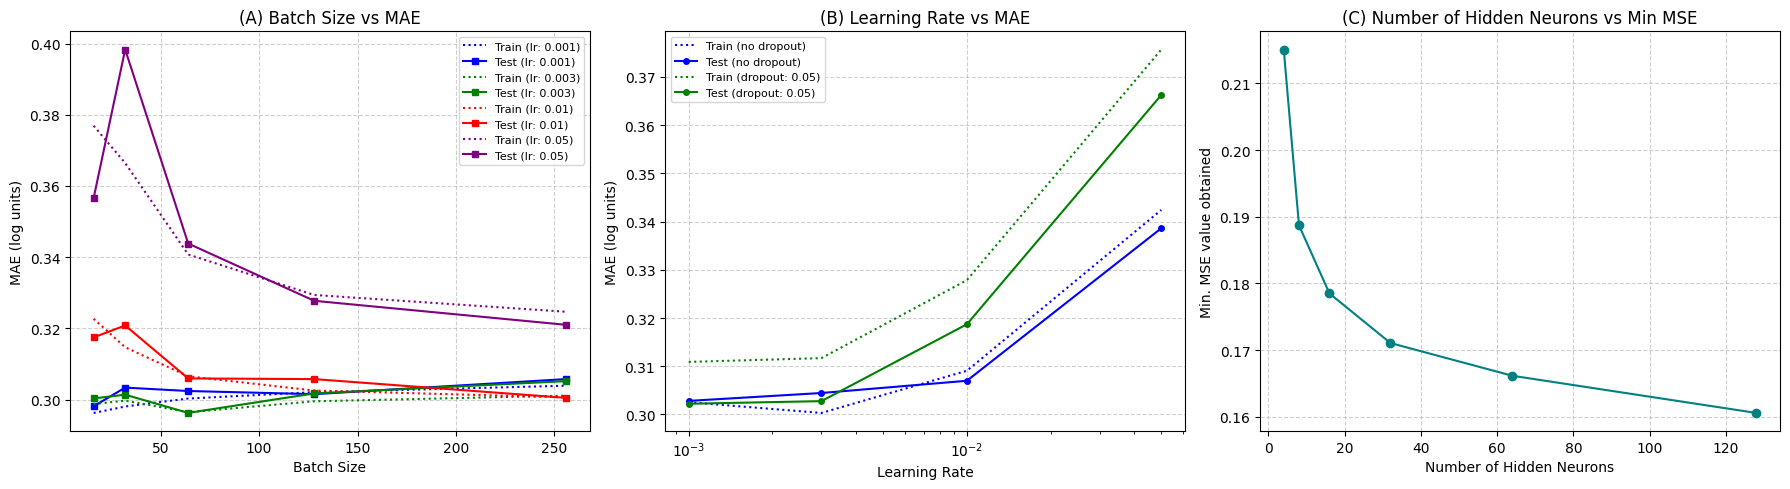


BEST PARAMETERS FOUND DURING TUNING:
Learning Rate : 0.003
Batch Size    : 64
Dropout Rate  : 0.0
Neurons       : 128

Training final model with best parameters for 100 epochs...
   Epoch 1: Train MSE = 0.2587, Val MSE = 0.1854
   Epoch 2: Train MSE = 0.1951, Val MSE = 0.1852
   Epoch 3: Train MSE = 0.1934, Val MSE = 0.1795
   Epoch 4: Train MSE = 0.1915, Val MSE = 0.1806
   Epoch 5: Train MSE = 0.1887, Val MSE = 0.1794
   Epoch 6: Train MSE = 0.1871, Val MSE = 0.1830
   Epoch 7: Train MSE = 0.1869, Val MSE = 0.1766
   Epoch 8: Train MSE = 0.1845, Val MSE = 0.1731
   Epoch 9: Train MSE = 0.1831, Val MSE = 0.1767
   Epoch 10: Train MSE = 0.1826, Val MSE = 0.1698
   Epoch 11: Train MSE = 0.1813, Val MSE = 0.1694
   Epoch 12: Train MSE = 0.1791, Val MSE = 0.1714
   Epoch 13: Train MSE = 0.1788, Val MSE = 0.1748
   Epoch 14: Train MSE = 0.1784, Val MSE = 0.1718
   Epoch 15: Train MSE = 0.1775, Val MSE = 0.1755
   Epoch 16: Train MSE = 0.1763, Val MSE = 0.1669
   Epoch 17: Train MSE = 0.17

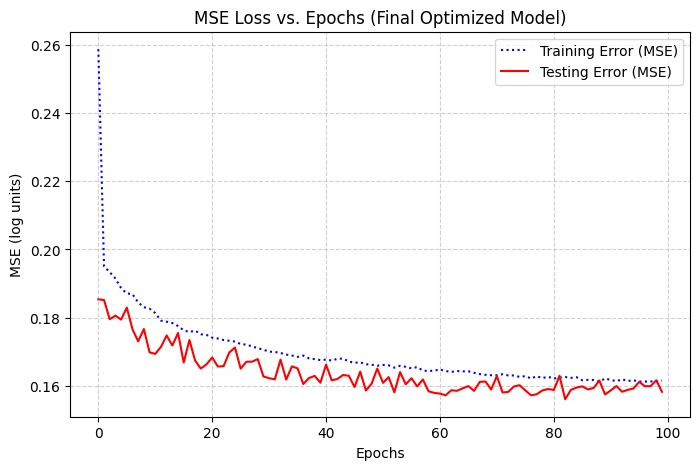


FINAL MODEL METRICS (TEST SET):
Final Test MSE : 0.1583
Final Test MAE : 0.2904


In [5]:
# ==========================================
# 0. GOOGLE COLAB SETUP
# ==========================================
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

# Mount Google Drive
drive.mount('/content/drive')

# ==========================================
# 1. LOAD DATA
# ==========================================
# Fixed the path to include the leading slash required by Colab
file_path = "/content/drive/MyDrive/FlatFiles/NGAsub_MegaFlatfile_RotD50_050_R211022_public.xlsx"
print(f"Loading data from {file_path}...")
df = pd.read_excel(file_path)

# ==========================================
# 2. FILTERING
# ==========================================
df_fil = df[
    (df['Earthquake_Magnitude'] >= 4) &
    (df['ClstD_km'] > 0) &
    (df['Vs30_Selected_for_Analysis_m_s'] > 0) &
    (df['PGA_g'] > 0) &
    (df['PGV_cm_sec'] > 0) &
    (df['Fault_Type'].notna())
].copy()

# ==========================================
# 3. FEATURE ENGINEERING (INPUTS)
# ==========================================
X = pd.DataFrame()

X['Mw'] = df_fil['Earthquake_Magnitude']
X['log10_Vs30'] = np.log10(df_fil['Vs30_Selected_for_Analysis_m_s'])
X['R_rup'] = df_fil['ClstD_km']
X['log10_R_rup'] = np.log10(df_fil['ClstD_km'])

fault_dummies = pd.get_dummies(df_fil['Fault_Type'], prefix='F')
X = pd.concat([X, fault_dummies], axis=1)

# ==========================================
# 4. TARGET ENGINEERING (OUTPUTS)
# ==========================================
y = pd.DataFrame()
y['log10_PGA'] = np.log10(df_fil['PGA_g'])
y['log10_PGV'] = np.log10(df_fil['PGV_cm_sec'])
y['log10_PSA_0.1s'] = np.log10(df_fil['T0pt100S'])
y['log10_PSA_1.0s'] = np.log10(df_fil['T1pt000S'])

# ==========================================
# 5. SPLIT AND SCALE
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("Data Prepared Successfully.")
print(f"Input Features: {X.columns.tolist()}")
print(f"Targets: {y.columns.tolist()}")
print(f"Training Samples: {X_train.shape[0]}")

# ==========================================
# 6. MODEL BUILDER
# ==========================================
def build_model(n_neurons=64, learning_rate=0.01, dropout_rate=0.0, input_dim=X_train_scaled.shape[1]):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    model.add(layers.Dense(n_neurons, activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(n_neurons // 2, activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(y_train.shape[1], activation='linear'))

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    return model

# Custom Callback to explicitly print MSE during each iteration (epoch)
print_mse_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"   Epoch {epoch + 1}: Train MSE = {logs['loss']:.4f}, Val MSE = {logs['val_loss']:.4f}")
)

best_val_mae_overall = float('inf')
best_params = {'lr': None, 'batch_size': None, 'dropout': None, 'neurons': None}



# ==========================================
# EXPERIMENT 1: BATCH SIZE vs LEARNING RATE
# ==========================================
print("\n--- Running Experiment 1: Batch Size vs LR ---")
batch_sizes = [16, 32, 64, 128, 256]
learning_rates = [0.001, 0.003, 0.01, 0.05]
res_exp1 = []

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\nTraining Model - LR: {lr}, Batch Size: {bs}")
        model = build_model(n_neurons=64, learning_rate=lr, dropout_rate=0.0)
        history = model.fit(
            X_train_scaled, y_train,
            epochs=40, batch_size=bs,
            verbose=0, # Keras progress bar turned off for cleanliness
            callbacks=[print_mse_callback], # Custom MSE print
            validation_data=(X_test_scaled, y_test)
        )

        train_mae = history.history['mae'][-1]
        val_mae = history.history['val_mae'][-1]
        res_exp1.append({'lr': lr, 'bs': bs, 'train_mae': train_mae, 'val_mae': val_mae})

        if val_mae < best_val_mae_overall:
            best_val_mae_overall = val_mae
            best_params.update({'lr': lr, 'batch_size': bs, 'dropout': 0.0, 'neurons': 64})

df_exp1 = pd.DataFrame(res_exp1)

# ==========================================
# EXPERIMENT 2: LEARNING RATE vs DROPOUT
# ==========================================
print("\n--- Running Experiment 2: LR vs Dropout ---")
dropouts = [0.0, 0.05]
fixed_bs = best_params['batch_size'] if best_params['batch_size'] else 32
res_exp2 = []

for drop in dropouts:
    for lr in learning_rates:
        print(f"\nTraining Model - LR: {lr}, Dropout: {drop}")
        model = build_model(n_neurons=64, learning_rate=lr, dropout_rate=drop)
        history = model.fit(
            X_train_scaled, y_train,
            epochs=40, batch_size=fixed_bs,
            verbose=0,
            callbacks=[print_mse_callback],
            validation_data=(X_test_scaled, y_test)
        )

        train_mae = history.history['mae'][-1]
        val_mae = history.history['val_mae'][-1]
        res_exp2.append({'lr': lr, 'dropout': drop, 'train_mae': train_mae, 'val_mae': val_mae})

        if val_mae < best_val_mae_overall:
            best_val_mae_overall = val_mae
            best_params.update({'lr': lr, 'batch_size': fixed_bs, 'dropout': drop, 'neurons': 64})

df_exp2 = pd.DataFrame(res_exp2)

# ==========================================
# EXPERIMENT 3: MIN MSE vs HIDDEN NEURONS
# ==========================================
print("\n--- Running Experiment 3: Optimization of Neurons ---")
neurons_list = [4, 8, 16, 32, 64, 128]
fixed_lr = best_params['lr']
fixed_drop = best_params['dropout']
res_exp3 = {'neurons': [], 'min_mse': []}

for n in neurons_list:
    print(f"\nTraining Model - Neurons: {n}")
    model = build_model(n_neurons=n, learning_rate=fixed_lr, dropout_rate=fixed_drop)
    history = model.fit(
        X_train_scaled, y_train,
        epochs=40, batch_size=fixed_bs,
        verbose=0,
        callbacks=[print_mse_callback],
        validation_data=(X_test_scaled, y_test)
    )

    min_val_mse = min(history.history['val_loss'])
    res_exp3['neurons'].append(n)
    res_exp3['min_mse'].append(min_val_mse)

    val_mae = history.history['val_mae'][-1]
    if val_mae < best_val_mae_overall:
        best_val_mae_overall = val_mae
        best_params['neurons'] = n

# ==========================================
# PLOTTING THE 3 EXPERIMENTS
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'green', 'red', 'purple', 'orange']

for idx, lr in enumerate(learning_rates):
    subset = df_exp1[df_exp1['lr'] == lr]
    color = colors[idx % len(colors)]
    axes[0].plot(subset['bs'], subset['train_mae'], linestyle=':', color=color, label=f'Train (lr: {lr})')
    axes[0].plot(subset['bs'], subset['val_mae'], linestyle='-', marker='s', markersize=4, color=color, label=f'Test (lr: {lr})')
axes[0].set_title('(A) Batch Size vs MAE')
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('MAE (log units)')
axes[0].grid(True, ls='--', alpha=0.6)
axes[0].legend(fontsize=8)

for idx, drop in enumerate(dropouts):
    subset = df_exp2[df_exp2['dropout'] == drop]
    color = colors[idx % len(colors)]
    drop_label = "no dropout" if drop == 0.0 else f"dropout: {drop}"
    axes[1].plot(subset['lr'], subset['train_mae'], linestyle=':', color=color, label=f'Train ({drop_label})')
    axes[1].plot(subset['lr'], subset['val_mae'], linestyle='-', marker='o', markersize=4, color=color, label=f'Test ({drop_label})')
axes[1].set_xscale('log')
axes[1].set_title('(B) Learning Rate vs MAE')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('MAE (log units)')
axes[1].grid(True, ls='--', alpha=0.6)
axes[1].legend(fontsize=8)

axes[2].plot(res_exp3['neurons'], res_exp3['min_mse'], marker='o', color='teal', linestyle='-')
axes[2].set_title('(C) Number of Hidden Neurons vs Min MSE')
axes[2].set_xlabel('Number of Hidden Neurons')
axes[2].set_ylabel('Min. MSE value obtained')
axes[2].grid(True, ls='--', alpha=0.6)

plt.tight_layout()
plt.show()

# ==========================================
# FINAL MODEL TRAINING & EVALUATION
# ==========================================
print("\n" + "="*40)
print("BEST PARAMETERS FOUND DURING TUNING:")
print(f"Learning Rate : {best_params['lr']}")
print(f"Batch Size    : {best_params['batch_size']}")
print(f"Dropout Rate  : {best_params['dropout']}")
print(f"Neurons       : {best_params['neurons']}")
print("="*40 + "\n")

print("Training final model with best parameters for 100 epochs...")
final_model = build_model(
    n_neurons=best_params['neurons'],
    learning_rate=best_params['lr'],
    dropout_rate=best_params['dropout']
)

final_history = final_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=best_params['batch_size'],
    verbose=0,
    callbacks=[print_mse_callback],
    validation_data=(X_test_scaled, y_test)
)



# Plot Final Model Learning Curve (MSE vs Epochs)
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Training Error (MSE)', color='blue', linestyle=':')
plt.plot(final_history.history['val_loss'], label='Testing Error (MSE)', color='red', linestyle='-')
plt.title('MSE Loss vs. Epochs (Final Optimized Model)')
plt.xlabel('Epochs')
plt.ylabel('MSE (log units)')
plt.legend()
plt.grid(True, ls='--', alpha=0.6)
plt.show()

final_loss, final_mae = final_model.evaluate(X_test_scaled, y_test, verbose=0)
print("\n" + "="*40)
print("FINAL MODEL METRICS (TEST SET):")
print(f"Final Test MSE : {final_loss:.4f}")
print(f"Final Test MAE : {final_mae:.4f}")
print("="*40)

<>:95: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
<>:104: SyntaxWarning: invalid escape sequence '\p'
<>:108: SyntaxWarning: invalid escape sequence '\p'
<>:95: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
<>:104: SyntaxWarning: invalid escape sequence '\p'
<>:108: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-4046635109.py:95: SyntaxWarning: invalid escape sequence '\p'
  r'Closest distance to Rupture, $R_{rup}$ (km)', 'Intra-Event Residual ($\phi$)',
/tmp/ipython-input-4046635109.py:99: SyntaxWarning: invalid escape sequence '\p'
  r'Closest distance to Rupture, $R_{rup}$ (km)', 'Intra-Event Residual ($\phi$)',
/tmp/ipython-input-4046635109.py:104: SyntaxWarning: invalid escape sequence '\p'
  r'Shear wave velocity, $V_{s30}$ (m/s)', 'Intra-Event Residual ($\phi$)',
/tmp/ipython-input-4046635109.py:108: SyntaxWarning: invalid escape sequence '\p'
  r'Shear wave veloc

Calculating residuals for analysis...


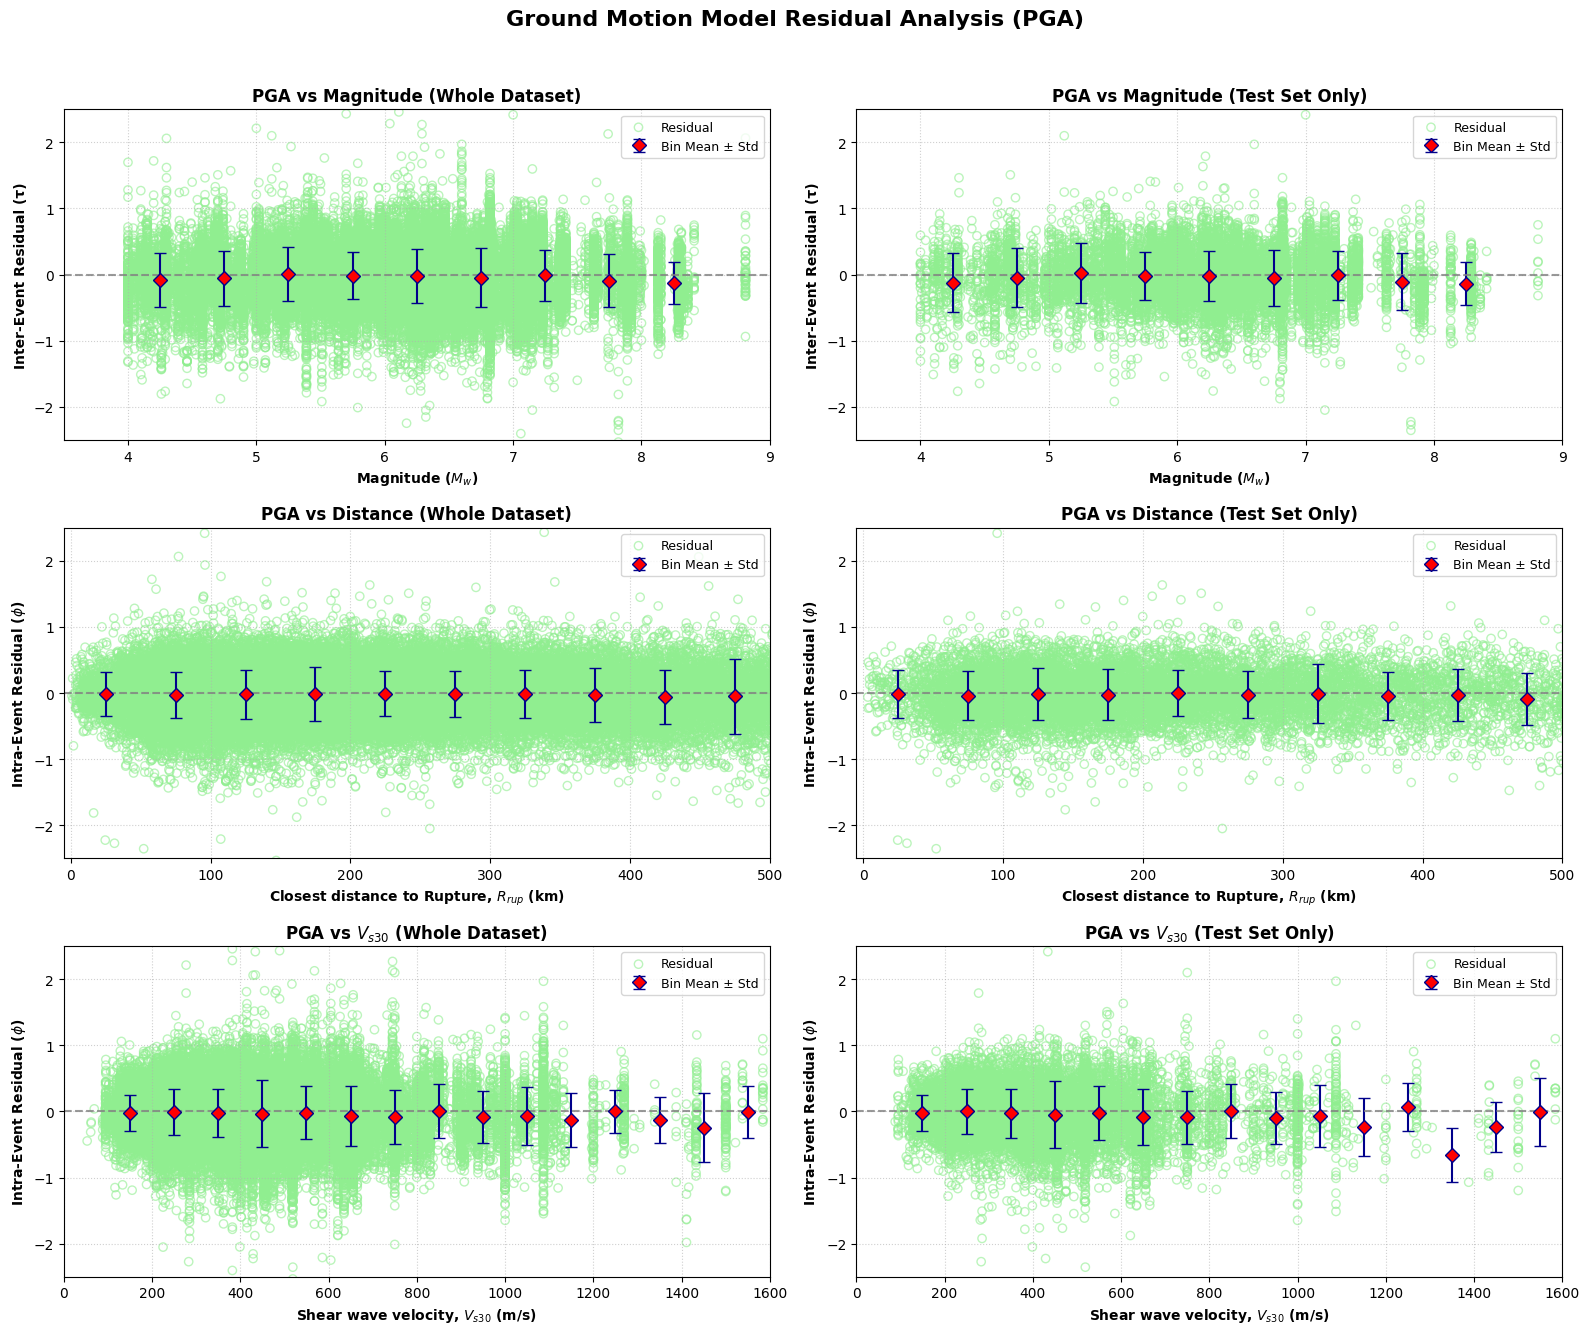

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. CALCULATE PREDICTIONS AND RESIDUALS (ONCE)
# ==========================================
print("Calculating residuals for analysis...")

# --- FOR ENTIRE DATASET ---
X_scaled = scaler_X.transform(X) # Note: Use transform, not fit_transform here
predictions_all = final_model.predict(X_scaled, verbose=0)

actual_log_pga_all = y['log10_PGA'].values
predicted_log_pga_all = predictions_all[:, 0]
residuals_all = actual_log_pga_all - predicted_log_pga_all

# --- FOR TEST SET ONLY ---
test_predictions = final_model.predict(X_test_scaled, verbose=0)

actual_test_log_pga = y_test['log10_PGA'].values
predicted_test_log_pga = test_predictions[:, 0]
residuals_test = actual_test_log_pga - predicted_test_log_pga

# ==========================================
# 2. REUSABLE PLOTTING FUNCTION
# ==========================================
def plot_residual_panel(ax, x_data, residuals, bins, xlabel, ylabel, title, xlim):
    """Handles the binning and scatter/errorbar plotting for any given feature."""
    bin_centers = bins[:-1] + np.diff(bins) / 2
    bin_means, bin_stds = [], []

    # Calculate mean and std for each bin
    for i in range(len(bins)-1):
        mask = (x_data >= bins[i]) & (x_data < bins[i+1])
        if np.sum(mask) > 0:
            bin_means.append(np.mean(residuals[mask]))
            bin_stds.append(np.std(residuals[mask]))
        else:
            bin_means.append(np.nan)
            bin_stds.append(np.nan)

    # 1. Scatter all residuals (light green hollow circles)
    ax.scatter(x_data, residuals, facecolors='none', edgecolors='lightgreen',
               alpha=0.6, label='Residual')

    # 2. Plot the binned Means (Red Diamonds) and Std Devs (Blue Error Bars)
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='D', markerfacecolor='red',
                markeredgecolor='darkblue', ecolor='darkblue', markersize=7, capsize=4,
                label='Bin Mean \u00B1 Std', linestyle='None')

    # Formatting
    ax.axhline(0, color='gray', linestyle='--', alpha=0.8)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_ylim(-2.5, 2.5) # Standardized Y-axis for easy comparison
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(loc='upper right', fontsize=9)

# ==========================================
# 3. GENERATE PLOTS (SIDE-BY-SIDE)
# ==========================================

# Define bins
bins_mag = np.arange(3.0, 9.0, 0.5)
bins_dist = np.arange(0, 550, 50)
bins_vs = np.arange(100, 1700, 100)

# Extract specific unscaled features for X-axes
mag_all = X['Mw'].values
mag_test = X_test['Mw'].values

dist_all = X['R_rup'].values
dist_test = X_test['R_rup'].values

vs_all = 10 ** X['log10_Vs30'].values
vs_test = 10 ** X_test['log10_Vs30'].values

# Create a 3-Row, 2-Column Figure layout
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Ground Motion Model Residual Analysis (PGA)', fontsize=16, fontweight='bold', y=0.98)

# --- ROW 1: MAGNITUDE ---
plot_residual_panel(axes[0, 0], mag_all, residuals_all, bins_mag,
                    'Magnitude ($M_w$)', 'Inter-Event Residual (\u03C4)',
                    'PGA vs Magnitude (Whole Dataset)', (3.5, 9.0))

plot_residual_panel(axes[0, 1], mag_test, residuals_test, bins_mag,
                    'Magnitude ($M_w$)', 'Inter-Event Residual (\u03C4)',
                    'PGA vs Magnitude (Test Set Only)', (3.5, 9.0))

# --- ROW 2: DISTANCE ---
plot_residual_panel(axes[1, 0], dist_all, residuals_all, bins_dist,
                    r'Closest distance to Rupture, $R_{rup}$ (km)', 'Intra-Event Residual ($\phi$)',
                    'PGA vs Distance (Whole Dataset)', (-5, 500))

plot_residual_panel(axes[1, 1], dist_test, residuals_test, bins_dist,
                    r'Closest distance to Rupture, $R_{rup}$ (km)', 'Intra-Event Residual ($\phi$)',
                    'PGA vs Distance (Test Set Only)', (-5, 500))

# --- ROW 3: SHEAR WAVE VELOCITY (Vs30) ---
plot_residual_panel(axes[2, 0], vs_all, residuals_all, bins_vs,
                    r'Shear wave velocity, $V_{s30}$ (m/s)', 'Intra-Event Residual ($\phi$)',
                    'PGA vs $V_{s30}$ (Whole Dataset)', (0, 1600))

plot_residual_panel(axes[2, 1], vs_test, residuals_test, bins_vs,
                    r'Shear wave velocity, $V_{s30}$ (m/s)', 'Intra-Event Residual ($\phi$)',
                    'PGA vs $V_{s30}$ (Test Set Only)', (0, 1600))

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

Calculating SHAP values for Relative Importance...


  0%|          | 0/100 [00:00<?, ?it/s]

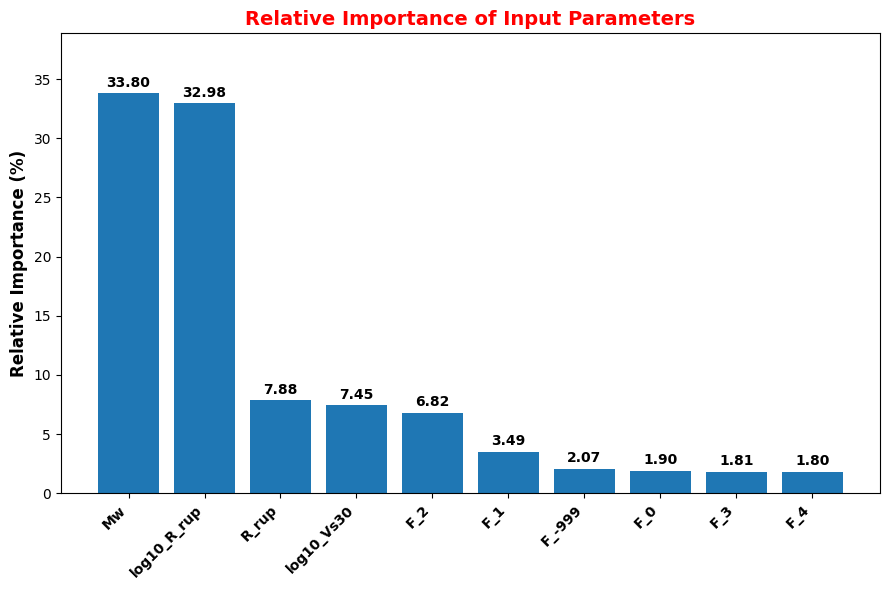

In [9]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# ==========================================
# 1. CALCULATE SHAP VALUES (If not already in memory)
# ==========================================
print("Calculating SHAP values for Relative Importance...")
tf.keras.utils.disable_interactive_logging()

# Safe wrapper to avoid Keras bug
def predict_wrapper(x):
    return final_model.predict(np.array(x), verbose=0)

# Use 10 centroids to prevent divide-by-zero errors
background_data = shap.kmeans(X_train_scaled, 10).data
explainer = shap.KernelExplainer(predict_wrapper, background_data)

# Calculate SHAP values for 100 test samples to get a stable importance metric
test_subset = X_test_scaled[:100]
shap_values = explainer.shap_values(test_subset, nsamples=100, progress_bar=False)

# ==========================================
# 2. PROCESS RELATIVE IMPORTANCE
# ==========================================
feature_names = X.columns.tolist()

# Convert list of 4 arrays (one per target) into a single 3D array
shap_array = np.array(shap_values)

# Average the absolute SHAP values across all 4 targets and all samples
# This gives exactly one global importance value per feature
# Fix: Change axis=(0, 1) to axis=(0, 2) to average over samples (axis 0) and targets (axis 2),
# leaving the feature dimension (axis 1) for importance calculation.
mean_abs_shap = np.abs(shap_array).mean(axis=(0, 2))

# Convert the raw values to percentages (so they sum to 100%)
importance_pct = (mean_abs_shap / mean_abs_shap.sum()) * 100

# Create a DataFrame and sort descending for the vertical plot
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_pct
}).sort_values(by='Importance', ascending=False)

# ==========================================
# 3. PLOT VERTICAL BAR CHART
# ==========================================
plt.figure(figsize=(9, 6))

# Plot vertical bars matching your reference image color
bars = plt.bar(df_importance['Feature'], df_importance['Importance'], color='#1f77b4')

# Formatting to match the image style
plt.ylabel('Relative Importance (%)', fontweight='bold', fontsize=12)
plt.title('Relative Importance of Input Parameters', fontweight='bold', fontsize=14, color='red')

# Set Y-axis limit slightly higher to leave room for the text labels
plt.ylim(0, max(df_importance['Importance']) * 1.15)

# Make X-axis labels readable (especially if one-hot encoded features are long)
plt.xticks(rotation=45, ha='right', fontweight='bold')

# Loop through each bar and add the numerical percentage on top
for bar in bars:
    yval = bar.get_height()
    # Position text in the center of the bar, slightly above the top
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f'{yval:.2f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

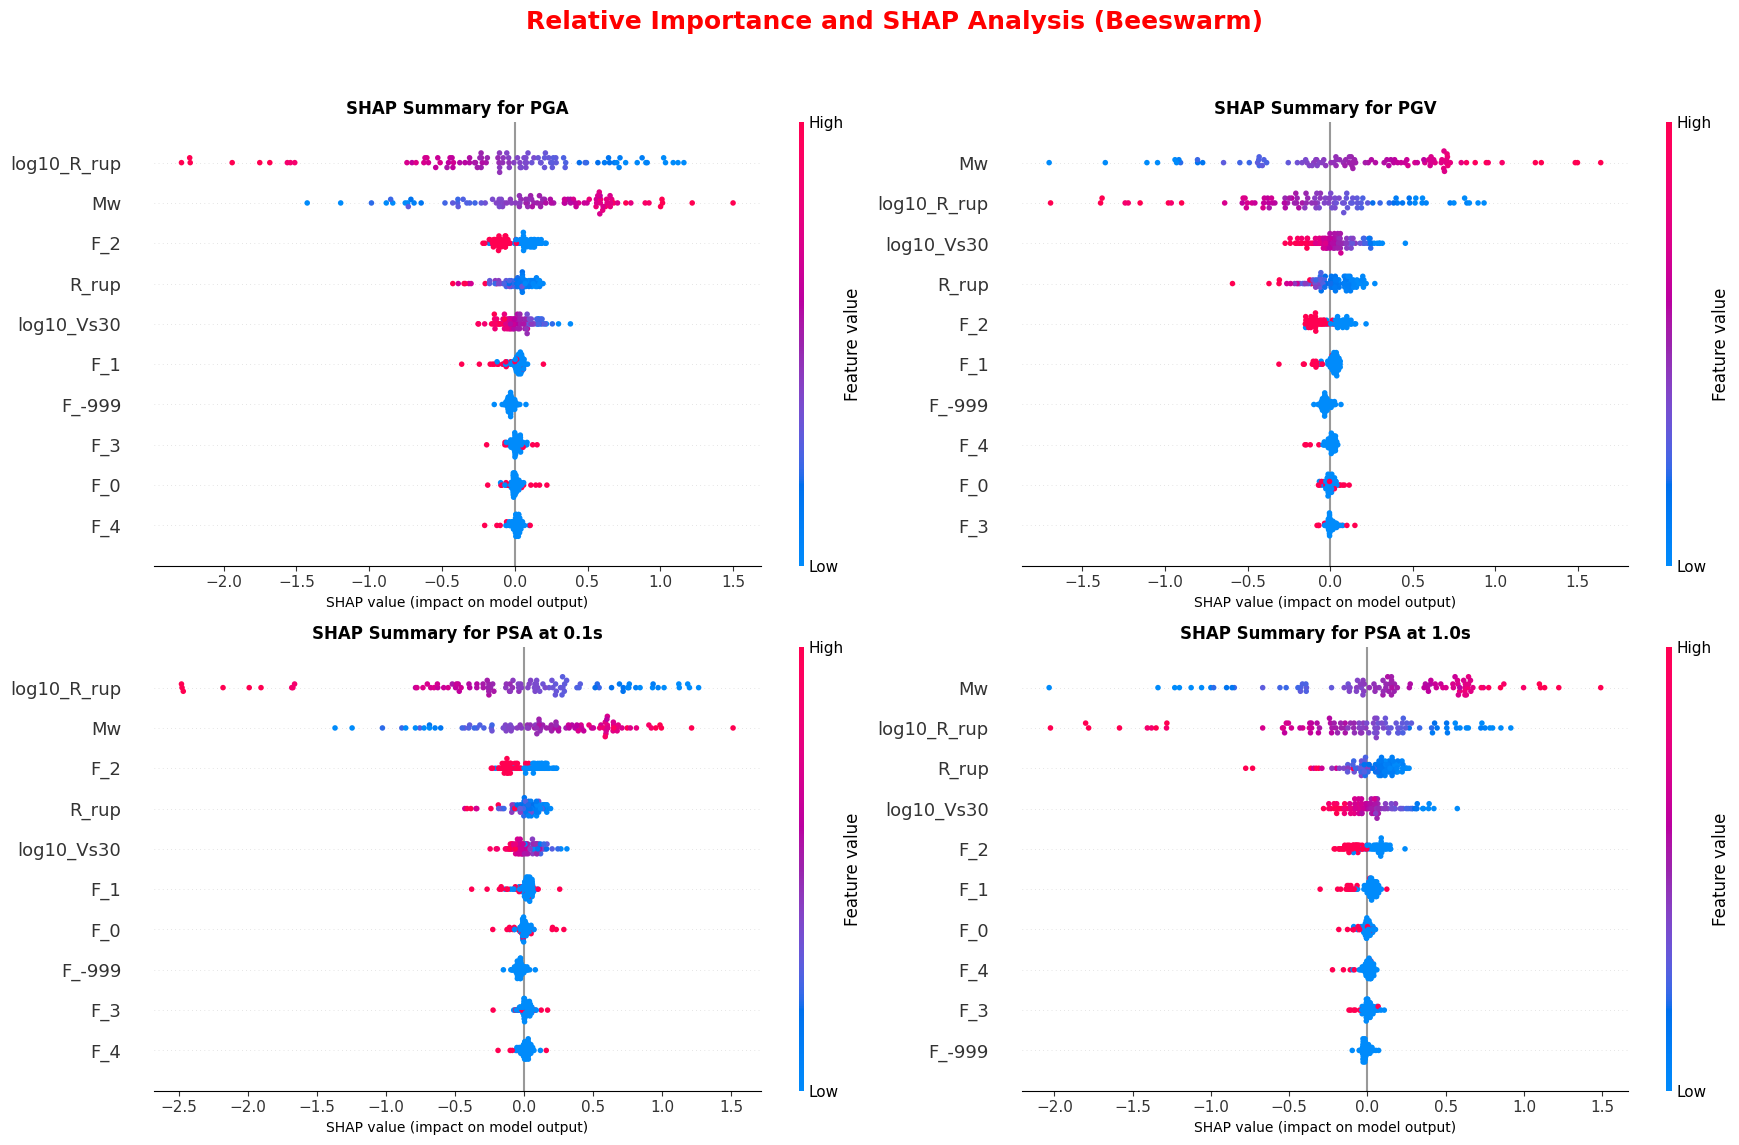

In [11]:
import matplotlib.pyplot as plt
import shap

# ==========================================
# SHAP BEESWARM SUMMARY PLOTS (2x2 GRID)
# ==========================================
# We assume 'shap_values' and 'test_subset' are already calculated
# from the previous KernelExplainer step.

# Grab the unscaled features for the exact same 100 test samples (to match shap_values).
# This makes the Red/Blue color mapping represent real physical values
# (e.g., Red = Mw 7.5, Blue = Mw 4.0) instead of scaled z-scores.
features_display = X_test.iloc[:100] # Changed from 50 to 100

# Define clean titles matching your 4 target outputs
# Note: Your code used PSA@0.1s, while the reference image used 0.2s.
# I am matching this to your actual model outputs.
plot_titles = ['PGA', 'PGV', 'PSA at 0.1s', 'PSA at 1.0s']

# Create the 2x2 figure layout
fig = plt.figure(figsize=(18, 12))
plt.suptitle('Relative Importance and SHAP Analysis (Beeswarm)',
             fontsize=18, fontweight='bold', color='red', y=0.98)

# Loop through each of the 4 model outputs
for i in range(4):
    plt.subplot(2, 2, i+1)

    # Generate the SHAP summary plot for the i-th target
    # shap_values[:, :, i] correctly extracts SHAP values for the i-th target,
    # across all 100 samples and 10 features, resulting in a (100, 10) array.
    # show=False forces SHAP to draw inside our custom subplot grid
    # plot_size=None tells SHAP not to override our figsize
    shap.summary_plot(
        shap_values[:, :, i], # Correct slicing for multi-output model
        features_display,
        show=False,
        plot_size=None
    )

    # Formatting the subplot
    plt.title(f'SHAP Summary for {plot_titles[i]}', fontsize=12, fontweight='bold')
    plt.xlabel('SHAP value (impact on model output)', fontsize=10)

# Adjust layout to prevent overlapping text and colorbars
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

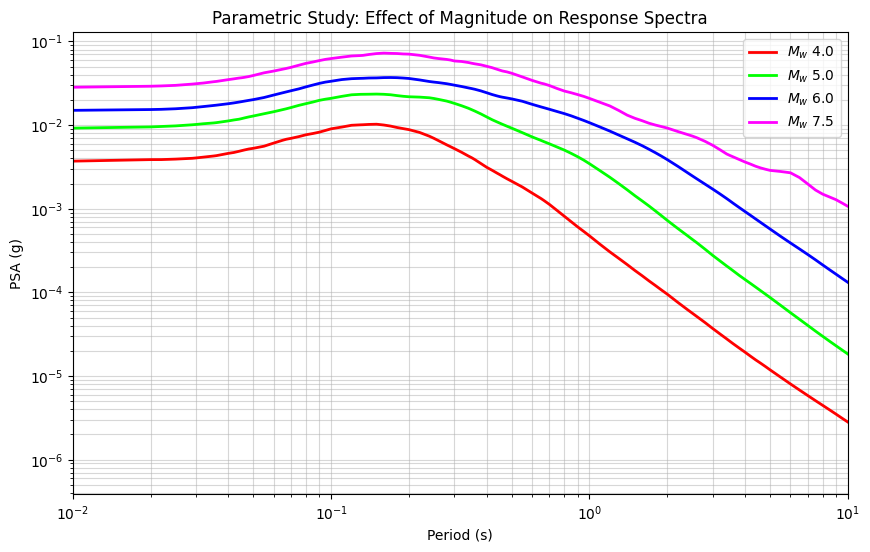

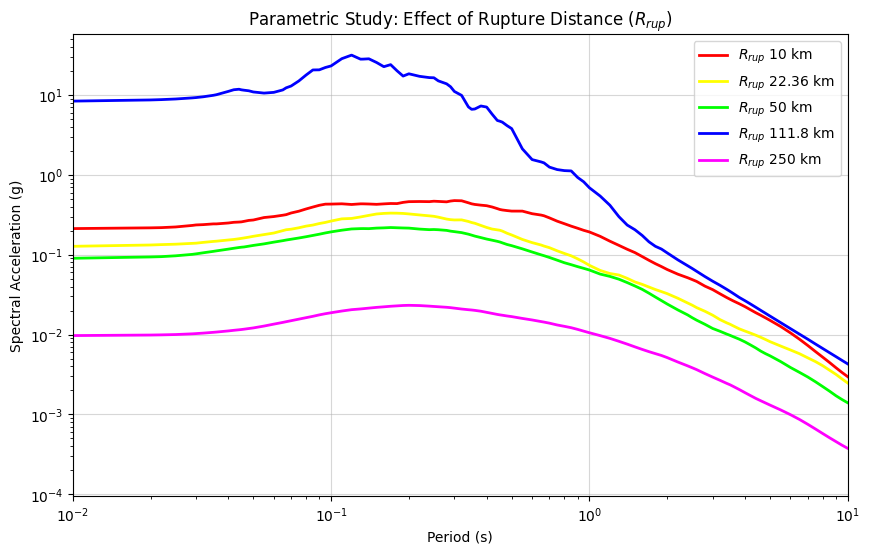

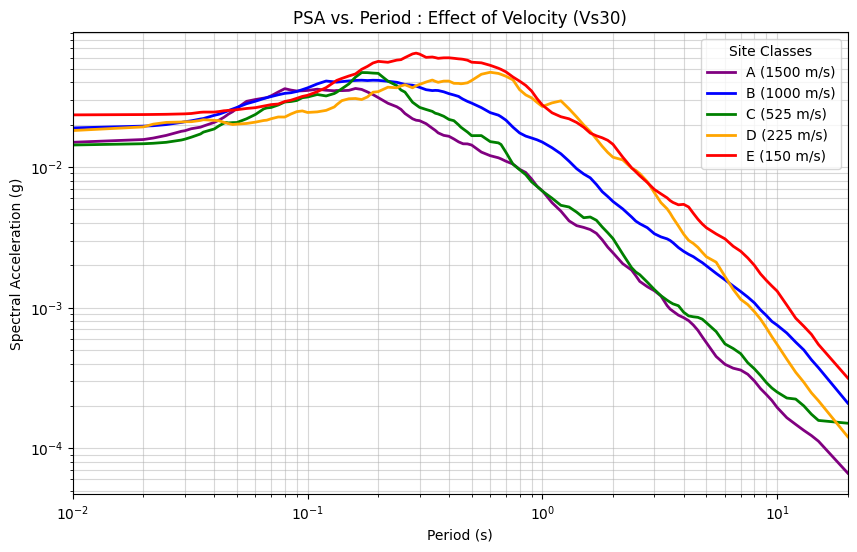

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================================================
# 1. PARAMETRIC STUDY: Effect of Magnitude on Response Spectra
# =====================================================================
# Define the Spectral Period columns available in your dataset
# These correspond to the T0pt010S to T20pt000S columns you listed
period_cols = [col for col in df_fil.columns if col.startswith('T') and col.endswith('S')]

# Convert column names to numerical periods (e.g., 'T0pt100S' -> 0.1)
periods = [float(col.replace('T', '').replace('pt', '.').replace('S', '')) for col in period_cols]

# Select specific Magnitudes for the study
target_magnitudes = [4.0, 5.0, 6.0, 7.5]
colors = ['red', 'lime', 'blue', 'magenta']

plt.figure(figsize=(10, 6))

for mag, color in zip(target_magnitudes, colors):
    # Filter for the specific magnitude
    # Using a small range to account for floating point precision in datasets
    subset = df_fil[(df_fil['Earthquake_Magnitude'] >= mag - 0.1) & (df_fil['Earthquake_Magnitude'] <= mag + 0.1)]

    if not subset.empty:
        # Calculate the mean PSA across all records of this magnitude to see the trend
        mean_psa = subset[period_cols].mean()
        plt.plot(periods, mean_psa, label=f'$M_w$ {mag}', color=color, linewidth=2)

# Formatting the plot to match Seismology standards
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period (s)')
plt.ylabel('PSA (g)')
plt.title('Parametric Study: Effect of Magnitude on Response Spectra')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.xlim(0.01, 10) # Adjust based on your usable period range
plt.show()

# =====================================================================
# 2. PARAMETRIC STUDY: Effect of Rupture Distance (Rrup)
# =====================================================================
# Define Rupture Distance bins (Rrup) for the study
# We use standard bins: 10km, 22km, 50km, 111km, 250km
distance_bins = [10, 22.36, 50, 111.8, 250]
colors = ['red', 'yellow', 'lime', 'blue', 'magenta']

plt.figure(figsize=(10, 6))

for dist, color in zip(distance_bins, colors):
    # Filter for the specific distance range
    # Note: Mw and Vs30 are NOT filtered, capturing their natural variability
    subset = df_fil[(df_fil['ClstD_km'] >= dist * 0.9) & (df_fil['ClstD_km'] <= dist * 1.1)]

    if not subset.empty:
        # Calculate the mean PSA for this distance bin
        mean_psa = subset[period_cols].mean()
        plt.plot(periods, mean_psa, label=f'$R_{{rup}}$ {dist} km', color=color, linewidth=2)

# Final Plot Formatting to match Seismology standards
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period (s)')
plt.ylabel('Spectral Acceleration (g)')
plt.title('Parametric Study: Effect of Rupture Distance ($R_{rup}$)')
plt.grid(True, linestyle="-", alpha=0.5)
plt.legend()
plt.xlim(0.01, 10)
plt.show()

# =====================================================================
# 3. PARAMETRIC STUDY: Effect of Velocity (Vs30)
# =====================================================================
# Define the 5 specific classes as shown in your reference images
site_classes = [
    ('A', 1500, 'purple'),
    ('B', 1000, 'blue'),
    ('C', 525, 'green'),
    ('D', 225, 'orange'),
    ('E', 150, 'red')
]

plt.figure(figsize=(10, 6))

for label, velocity, color in site_classes:
    # Select only the real data points matching these exact velocity values
    subset = df_fil[df_fil['Vs30_Selected_for_Analysis_m_s'] == velocity]

    if not subset.empty:
        # Calculate the mean PSA for the records existing at this velocity
        psa_values = subset[period_cols].mean()
        plt.plot(periods, psa_values, label=f'{label} ({velocity} m/s)', color=color, linewidth=2)

# Formatting the plot to match your requirement
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period (s)')
plt.ylabel('Spectral Acceleration (g)')
plt.title('PSA vs. Period : Effect of Velocity (Vs30)')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend(title="Site Classes")
plt.xlim(min(periods), max(periods))
plt.show()

Preparing data for Neural Additive Model...
Building NAM Architecture...

Training Neural Additive Model for 100 Epochs...


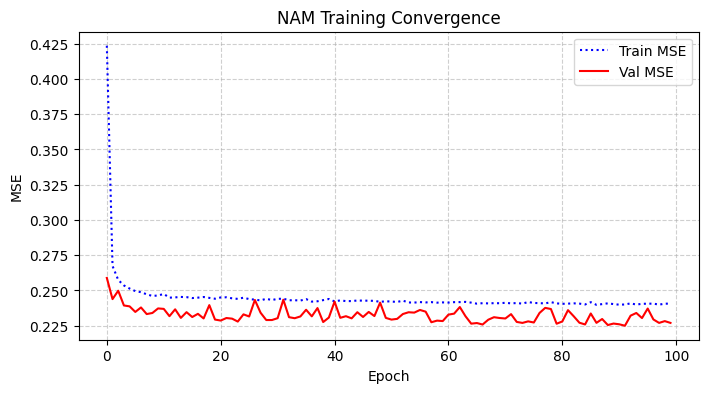

Final Test MSE: 0.2269 | Final Test MAE: 0.3427


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ==========================================
# 1. PREPARE SEPARATE INPUTS FOR NAM
# ==========================================
print("Preparing data for Neural Additive Model...")

# 1a. Define our continuous features (including both Raw and Log versions)
continuous_features = ['Mw', 'R_rup', 'log10_R_rup', 'Vs30', 'log10_Vs30']

# We need the raw Vs30 for our new input
if 'Vs30' not in X.columns:
    X['Vs30'] = df_fil['Vs30_Selected_for_Analysis_m_s']

# 1b. Define categorical features (Fault Types)
categorical_features = [col for col in X.columns if col.startswith('F_')]

# 1c. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1d. Scale Continuous Features INDIVIDUALLY
scalers = {}
X_train_scaled = pd.DataFrame(index=X_train.index)
X_test_scaled = pd.DataFrame(index=X_test.index)

for col in continuous_features:
    scaler = StandardScaler()
    X_train_scaled[col] = scaler.fit_transform(X_train[[col]])
    X_test_scaled[col] = scaler.transform(X_test[[col]])
    scalers[col] = scaler

for col in categorical_features:
    X_train_scaled[col] = X_train[col]
    X_test_scaled[col] = X_test[col]

# FIX: Update dictionary mapping to bundle categorical features together
def make_dataset_dict(df, cont_feats, cat_feats):
    # Add individual continuous features
    dataset_dict = {col: df[col].values for col in cont_feats}
    # Bundle all categorical features into a single matrix under the name 'Fault_Types'
    if cat_feats:
        dataset_dict['Fault_Types'] = df[cat_feats].values
    return dataset_dict

train_dict = make_dataset_dict(X_train_scaled, continuous_features, categorical_features)
test_dict = make_dataset_dict(X_test_scaled, continuous_features, categorical_features)

# ==========================================
# 2. BUILD THE NEURAL ADDITIVE MODEL (NAM)
# ==========================================
print("Building NAM Architecture...")

inputs = []
feature_outputs = []

# L1 Penalty to enforce sparsity
l1_reg = regularizers.l1(0.005)

# --- A. Mini-Networks for Continuous Features ---
for feature in continuous_features:
    inp = layers.Input(shape=(1,), name=feature)
    inputs.append(inp)

    x = layers.Dense(32, activation='relu')(inp)
    x = layers.Dense(32, activation='relu')(x)

    out = layers.Dense(y_train.shape[1], activation='linear',
                       kernel_regularizer=l1_reg, name=f'out_{feature}')(x)
    feature_outputs.append(out)

# --- B. Linear Weights for Categorical Features ---
if categorical_features:
    inp_cat = layers.Input(shape=(len(categorical_features),), name='Fault_Types')
    inputs.append(inp_cat)

    cat_out = layers.Dense(y_train.shape[1], activation='linear',
                           use_bias=False, kernel_regularizer=l1_reg, name='out_faults')(inp_cat)
    feature_outputs.append(cat_out)

# --- C. The Additive Sum ---
final_output = layers.Add(name='Additive_Sum')(feature_outputs)

nam_model = models.Model(inputs=inputs, outputs=final_output)
nam_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss='mse', metrics=['mae'])

# ==========================================
# 3. TRAIN THE NAM
# ==========================================
print("\nTraining Neural Additive Model for 100 Epochs...")

nam_history = nam_model.fit(
    x=train_dict,
    y=y_train.values,
    validation_data=(test_dict, y_test.values),
    epochs=100,
    batch_size=64,
    verbose=0
)

# Plot Training Curve
plt.figure(figsize=(8, 4))
plt.plot(nam_history.history['loss'], label='Train MSE', color='blue', linestyle=':')
plt.plot(nam_history.history['val_loss'], label='Val MSE', color='red')
plt.title('NAM Training Convergence')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, ls='--', alpha=0.6)
plt.show()

final_loss, final_mae = nam_model.evaluate(test_dict, y_test.values, verbose=0)
print(f"Final Test MSE: {final_loss:.4f} | Final Test MAE: {final_mae:.4f}")

Extracting learned shape functions using the Additive Isolation Method...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


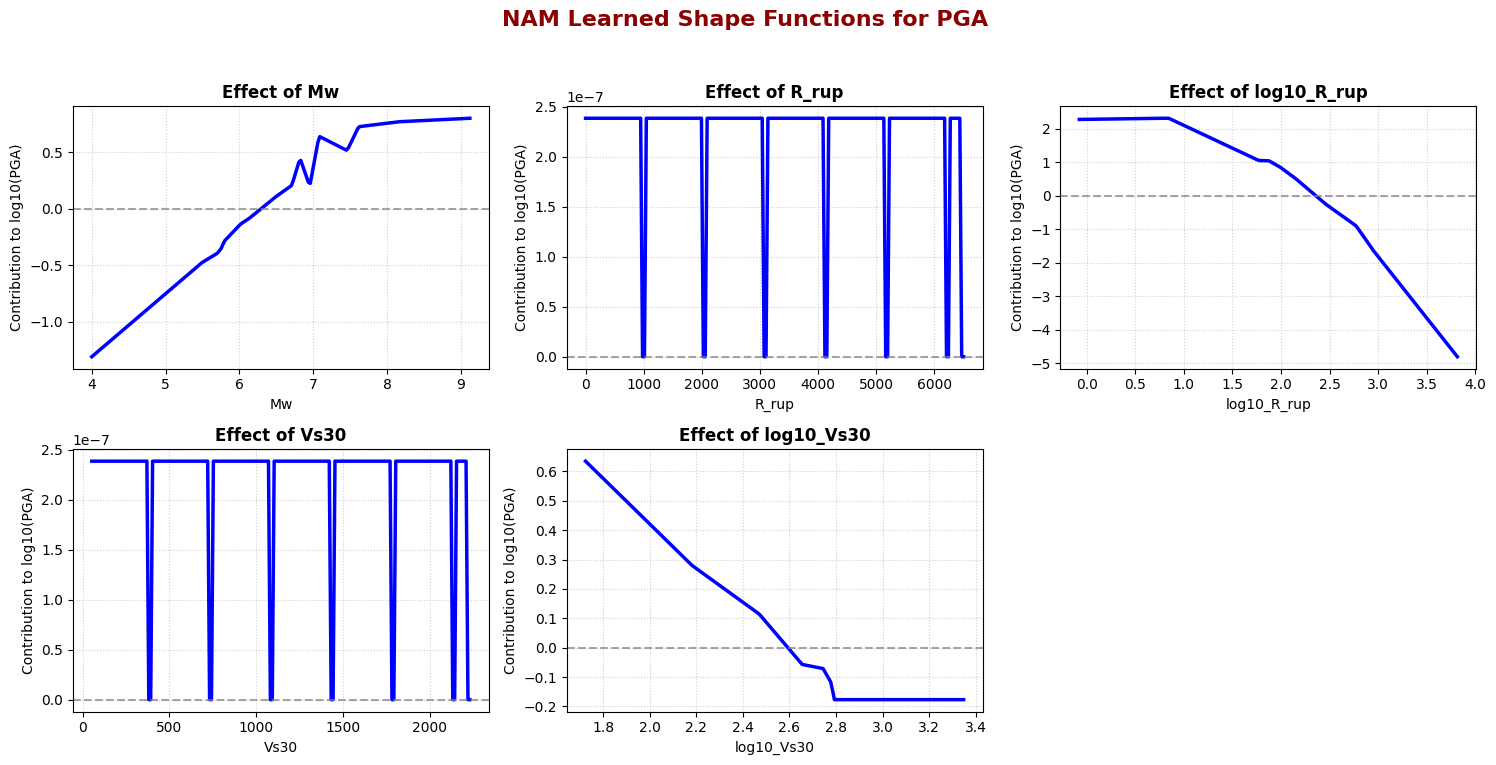

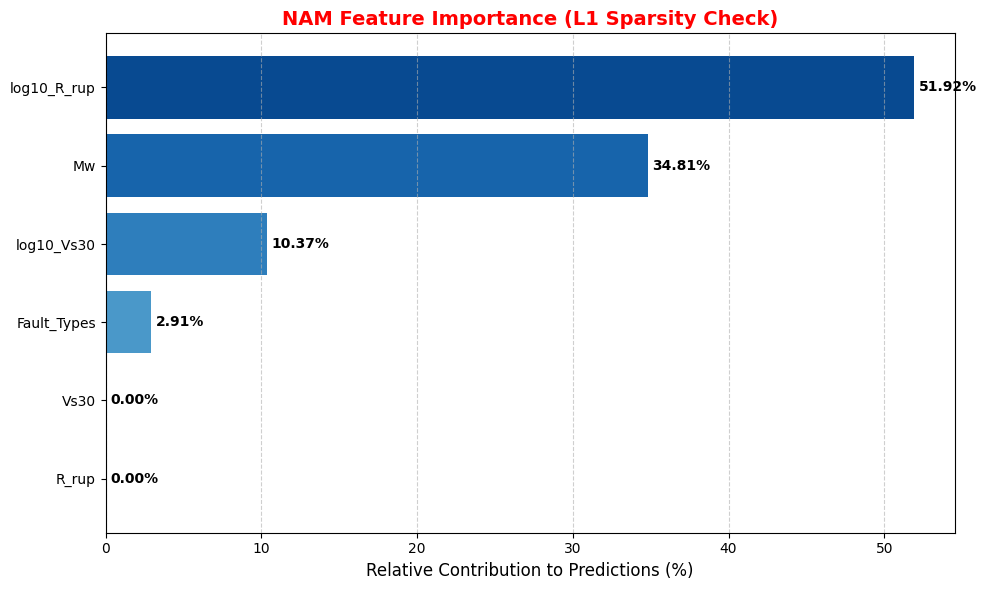

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print("Extracting learned shape functions using the Additive Isolation Method...")
tf.keras.utils.disable_interactive_logging()

target_idx = 0  # 0 corresponds to the first output (PGA)
target_name = "PGA"

# ==========================================
# 1. CALCULATE BASELINE (All inputs = 0)
# ==========================================
# Scaled 0 means the "average" earthquake in the dataset.
baseline_dict = {}
for feature in continuous_features:
    baseline_dict[feature] = np.zeros((1, 1))
if categorical_features:
    baseline_dict['Fault_Types'] = np.zeros((1, len(categorical_features)))

# Baseline prediction for all 4 targets
baseline_preds_all = nam_model.predict(baseline_dict)
baseline_pga = baseline_preds_all[0, target_idx]

# ==========================================
# 2. PLOT SHAPE FUNCTIONS & CALCULATE IMPORTANCE
# ==========================================
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f'NAM Learned Shape Functions for {target_name}', fontsize=16, fontweight='bold', color='darkred')
axes = axes.flatten()

importance_scores = {}

for i, feature in enumerate(continuous_features):
    ax = axes[i]

    # 1. Create a range of values for the current feature
    raw_values = np.linspace(X[feature].min(), X[feature].max(), 200).reshape(-1, 1)
    scaled_values = scalers[feature].transform(raw_values)

    # 2. ISOLATE: Set all other features to 0
    pred_dict = {}
    for other_feat in continuous_features:
        if other_feat == feature:
            pred_dict[other_feat] = scaled_values
        else:
            pred_dict[other_feat] = np.zeros_like(scaled_values)

    if categorical_features:
        pred_dict['Fault_Types'] = np.zeros((len(scaled_values), len(categorical_features)))

    # 3. Predict and subtract baseline to get pure isolated contribution
    shape_contribution = nam_model.predict(pred_dict)[:, target_idx] - baseline_pga

    # Plotting
    ax.plot(raw_values, shape_contribution, color='blue', linewidth=2.5)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.7)
    ax.set_title(f'Effect of {feature}', fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Contribution to log10({target_name})')
    ax.grid(True, ls=':', alpha=0.6)

    # ----------------------------------------------------
    # Calculate Importance for this feature over the Test Set
    # ----------------------------------------------------
    test_dict_isolated = {}
    for other_feat in continuous_features:
        if other_feat == feature:
            test_dict_isolated[other_feat] = X_test_scaled[feature].values.reshape(-1, 1)
        else:
            test_dict_isolated[other_feat] = np.zeros((len(X_test), 1))
    if categorical_features:
        test_dict_isolated['Fault_Types'] = np.zeros((len(X_test), len(categorical_features)))

    # Predict all 4 targets, subtract baseline, and take Mean Absolute Error
    test_contributions = nam_model.predict(test_dict_isolated) - baseline_preds_all
    importance_scores[feature] = np.mean(np.abs(test_contributions))

# Hide the last empty subplot
axes[5].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ==========================================
# 3. CALCULATE AND PLOT FAULT TYPE IMPORTANCE
# ==========================================
if categorical_features:
    test_dict_cat = {}
    for feat in continuous_features:
        test_dict_cat[feat] = np.zeros((len(X_test), 1))
    test_dict_cat['Fault_Types'] = X_test[categorical_features].values

    cat_contributions = nam_model.predict(test_dict_cat) - baseline_preds_all
    importance_scores['Fault_Types'] = np.mean(np.abs(cat_contributions))

# ==========================================
# 4. PLOT RELATIVE IMPORTANCE (BAR CHART)
# ==========================================
total_importance = sum(importance_scores.values())
importance_pct = {k: (v / total_importance) * 100 for k, v in importance_scores.items()}

df_nam_imp = pd.DataFrame(list(importance_pct.items()), columns=['Feature', 'Importance'])
df_nam_imp = df_nam_imp.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(df_nam_imp)))
bars = plt.barh(df_nam_imp['Feature'], df_nam_imp['Importance'], color=colors)

plt.title('NAM Feature Importance (L1 Sparsity Check)', fontsize=14, color='red', fontweight='bold')
plt.xlabel('Relative Contribution to Predictions (%)', fontsize=12)
plt.grid(axis='x', ls='--', alpha=0.6)

for i, v in enumerate(df_nam_imp['Importance']):
    plt.text(v + 0.3, i, f'{v:.2f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()